# Model traning

In [30]:
#Zaimportowanie wymaganych bibliotek
import os
import numpy as np
import pandas as pd
from pathlib import Path
from keras.layers import Input, Reshape, Dropout, Dense, Flatten, BatchNormalization, Activation, ZeroPadding2D, LeakyReLU, Conv2DTranspose
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.losses import binary_crossentropy
from numpy import zeros,ones,vstack
from numpy.random import randn,randint,normal,random,choice
from numpy.random import default_rng
from IPython.display import clear_output
from math import trunc

from matplotlib import pyplot as plt

from PIL import Image

Parameters & data loading

In [160]:
#Parametry
VERSION=1.0

#can be cub-cubism or del-delaunay
#DATA="cubism"
DATA="delaunay"
#DATA="wikiart"


#Number of saved images during training
OUTPUT = 5 # grid of output x output images
# For now there is no margin between images
SAVE_FREQ = 5 #How often to save images and models
OVERRIDE_MODEL = False #Option to either save latest model or all of them
OUTPUT_PATH='output\\new\\' # where to save images
STAT_PATH="output\\statistics\\" # where to save stats
'''
In this use case, our latent space representations are used to
transform more complex forms of raw data (i.e. images, video),
into simpler representations which are "more convenient to process" and analyze.
'''
NOISE_SIZE = 128#Lantent dimention size

EPOCHS = 5000 #Iterations the biger, the longer the model will train
BATCH_SIZE = 10 #number of images in the Batch. Larger Batch → Weak Generalization, Larger Batches → Fewer updates + shifting data → lower computational costs

#Columns of stats
STATS=[["Epoch","batch_t","d_loss","g_loss","acc_real","acc_fake"]]

In [161]:
if DATA =="delaunay":
    DATASET_NAME="del"
    PATH_TO_DATA='data\\delaunay_data_norm.npy'
elif DATA =="cubism":
    DATASET_NAME="cub"
    PATH_TO_DATA='data\\cubism_data_norm.npy'
else:
    DATASET_NAME="wikiart"
    PATH_TO_DATA='data\\wikiart_data_norm.npy'

In [162]:
#data load
train_data = np.load(PATH_TO_DATA)
print("(number of images, size_x, size_y, color_channels)")
print(train_data.shape)
#checking if the images are square
if train_data.shape[1]!=train_data.shape[2]:
    print("Something is wrong")

(number of images, size_x, size_y, color_channels)
(11503, 64, 64, 3)


In [163]:
#size of images
IMG_SIZE = train_data.shape[1] #rows/cols
IMG_CHANNELS = train_data.shape[3] #color channels in our images
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS) #shape of images

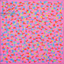

In [164]:
#Image example
Image.fromarray(((train_data[1]+1)*255/2).astype(np.uint8))

Functions

In [165]:
#discriminator
def build_discriminator(image_shape):
    model = Sequential(name="Discriminator")
    init = RandomNormal(mean=0.0, stddev=0.02)
    
    model.add(Conv2D(64, kernel_size=4, strides=2, padding="same",
                     input_shape=image_shape, data_format="channels_last", kernel_initializer=init, use_bias=False))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.20))    

    model.add(Conv2D(128, kernel_size=4, strides=2, padding="same", kernel_initializer=init, use_bias=False))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.20))    
    
    model.add(Conv2D(256, kernel_size=4, strides=2, padding="same",kernel_initializer=init, use_bias=False))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))    
    model.add(Dropout(0.20))
    
    model.add(Conv2D(512, kernel_size=4, strides=2, padding="same",kernel_initializer=init, use_bias=False))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))    
    model.add(Dropout(0.20))
    
    model.add(Conv2D(1024, kernel_size=4, strides=2, padding="same",kernel_initializer=init, use_bias=False))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))    
    model.add(Dropout(0.20))
    
    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid"))

    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss=binary_crossentropy, optimizer=opt, metrics=['accuracy'])
    model.summary()
    
    return model

In [166]:
#generator
def build_generator(noise_size, channels):
     model = Sequential(name="Generator")
     init = RandomNormal(mean=0.0, stddev=0.02)
     model.add(Dense(4 * 4 * 128,input_dim=noise_size,kernel_initializer=init,use_bias=False))
     #model.add(Activation("relu"))
     model.add(Reshape((4, 4, 128)))
     
     model.add(Conv2DTranspose(512,kernel_size=4, strides=2, padding="same",kernel_initializer=init,use_bias=False))
     model.add(BatchNormalization(momentum=0.8))
     model.add(Activation("relu"))
     
     model.add(Conv2DTranspose(256,kernel_size=4, strides=2, padding="same", kernel_initializer=init, use_bias=False))
     model.add(BatchNormalization(momentum=0.8))
     model.add(Activation("relu"))    

     model.add(Conv2DTranspose(128,kernel_size=4, strides=2, padding="same", kernel_initializer=init, use_bias=False))
     model.add(BatchNormalization(momentum=0.8))
     model.add(Activation("relu"))
     
     #model.add(Conv2DTranspose(128,kernel_size=4, strides=2, padding="same", kernel_initializer=init, use_bias=False))
     #model.add(BatchNormalization(momentum=0.8))
     #model.add(Activation("relu"))
     
     model.add(Conv2DTranspose(channels, kernel_size=4,strides=2, padding="same", kernel_initializer=init, use_bias=False))
     model.add(BatchNormalization(momentum=0.8))
     model.add(Activation("tanh"))

     model.summary()

     return model

In [167]:
#generative adversarial network
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential(name="GAN")
    model.add(generator)
    model.add(discriminator)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    model.summary()
    return model

In [168]:
#saving examples during training
def save_images(epoch,generator, noise):
    generated_images = generator.predict(noise)
    array=np.empty((IMG_SHAPE),float)
    count=0
    #creating a grid of images
    for i in range(OUTPUT):
        for j in range(OUTPUT):
            if j==0:
                array_pom=np.array(generated_images[count].reshape(64,64,3,order='C'))
            else:
                array_pom=np.concatenate((array_pom,np.array(
                    generated_images[count].reshape(64,64,3,order='C'))),axis=1)
            count+=1
        if i==0:
            array=array_pom
        else:
            array=np.concatenate((array,array_pom),axis=0)
    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)
    filename = os.path.join(OUTPUT_PATH, DATA+"_v_%.1f_e_%d.png"%(VERSION,epoch))
    #from (-1,1) to (0,255)
    im = Image.fromarray(((array+1)*255/2).astype(np.uint8))
    im.save(filename)

In [169]:
#getting real samples from the data
def get_real_samples(data, n_samples):
    indexes = randint(0, data.shape[0], n_samples)
    X = data[indexes]
    y = ones((n_samples, 1))
    return X, y

#generating fake samples using generator
def generate_fake_samples(generator, n_samples, noise):
    x_input = default_rng().normal(0.0, 1.0, (n_samples, noise))
    X = generator.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

#creating errors in labels 
def flip_labels(y, proc_to_flip):
 # determine the number of labels to flip
 n_select = int(proc_to_flip * y.shape[0])
 # choose labels to flip
 flip_ix = choice([i for i in range(y.shape[0])], size=n_select)
 # invert the labels in place
 y[flip_ix] = 1 - y[flip_ix]
 return y

In [170]:
#graf plotting and model saving
def summarize_performance(epoch, generator, stats=STATS):
    st=pd.DataFrame(stats[1:], columns=stats[0])
    fig, ax = plt.subplots(2, 1)
    ax[0].set_title("Loss")#Loss
    ax[0].plot(st.g_loss, label='generator')#on fake
    ax[0].plot(st.d_loss, label='discriminator')#on real
    ax[0].legend()
    ax[1].set_title("Accuracy")#Accuracy
    ax[1].plot(st.acc_fake, label='generator')#fake
    ax[1].plot(st.acc_real, label='discriminator')#real
    ax[1].legend()
    fig.suptitle("Epoch: %d"%(epoch))
    fig.tight_layout()
    #plt.savefig((STAT_PATH+"statistics_plot_v_%.1f.png" % (VERSION)))
    plt.show()
    st.to_csv((STAT_PATH+'stats_'+DATASET_NAME+'_%.1f.csv'%(VERSION)))
    plt.close()

In [171]:
#saving model
def save_generator(epoch, generator, override_model=OVERRIDE_MODEL):
    if override_model:
        filename = DATASET_NAME+'_model_v_%.1f.h5' % (VERSION)
    else:
        filename = DATASET_NAME+'_model_v_%.1f_e_%d.h5' % (VERSION,epoch)
    generator.save('models\\new\\'+filename,include_optimizer=True)

In [172]:
def train(generator, discriminator, gan_model, dataset, 
          noise=NOISE_SIZE, n_epochs=1000, n_batch=10):
    batchs_per_epoch = int(dataset.shape[0] / n_batch)
    batch_size_r=int(int(n_batch / 2))
    #generating fixed noise for images examples
    fixed_noise = default_rng().normal(
        loc=0.0, scale=1.0, size=(OUTPUT * OUTPUT, noise))
    i=0
    while i <= n_epochs:
        for j in range(batchs_per_epoch):
            #geting and generating samples
            X_real, y_real = get_real_samples(dataset, batch_size_r)
            X_fake, y_fake = generate_fake_samples(
                generator, n_batch-batch_size_r,  noise)
            X_gan = default_rng().normal(0.0, 1.0, (n_batch, noise))
            y_gan = ones((n_batch, 1))
            #creating errors in labels
            #y_real =flip_labels(y_real, 0.05)
            #y_fake =flip_labels(y_fake, 0.05)
            #stacking real and false images for traning
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            #training
            d_loss, acc_mix = discriminator.train_on_batch(X, y)
            _, acc_real = discriminator.evaluate(X_real, y_real, verbose=0)
            _, acc_fake = discriminator.evaluate(X_fake, y_fake, verbose=0)
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            STATS.append([i+1,(i)*batchs_per_epoch+(j+1), 
                          d_loss, g_loss, acc_real, acc_fake])
            print('Epoch:%d, Batch:%d/%d, d_loss=%.4f g_loss=%.4f' %
                  (i+1, j+1, batchs_per_epoch, d_loss, g_loss))
        if (i+1) % SAVE_FREQ == 0:
            #saving images generated from fixed noise
            save_images(i+1,generator, fixed_noise)
            save_generator(i+1,generator)
            clear_output()
            summarize_performance(i+1,STATS)
            print('Accuracy on real: %.0f%%, on fake: %.0f%%' % 
                  (acc_real*100, acc_fake*100))
            #increase the real batch part in discriminator training
            #with each save add 2,5%
            if batch_size_r<n_batch:
                batch_size_r+=int(int(n_batch / 80))            
        i+=1
            

Training

In [173]:
#run the training
discriminator = build_discriminator(IMG_SHAPE)
generator = build_generator(NOISE_SIZE, IMG_CHANNELS)
STATS=[STATS[0]]
gan_model = build_gan(generator, discriminator)
train(generator, discriminator, gan_model, np.array(train_data), NOISE_SIZE,EPOCHS)

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_142 (Conv2D)         (None, 32, 32, 64)        3072      
                                                                 
 leaky_re_lu_135 (LeakyReLU)  (None, 32, 32, 64)       0         
                                                                 
 dropout_133 (Dropout)       (None, 32, 32, 64)        0         
                                                                 
 conv2d_143 (Conv2D)         (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization_224 (Ba  (None, 16, 16, 128)      512       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_136 (LeakyReLU)  (None, 16, 16, 128)      0         
                                                     

Plotting

In [ ]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
col = STATS[0]
df = pd.read_csv("output\\statistics\\stats_cub_0.8.csv", usecols=col, sep=',',engine='python')
#print("Contents in csv file:", df)
plt.plot(df.acc_real, label='Dyskryminator')
plt.plot(df.acc_fake, label='Generator')
plt.title("Accuracy during traning")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
col = STATS[0]
df = pd.read_csv("output\\statistics\\stats_cub_0.8.csv", usecols=col,sep=',',engine='python')
#print("Contents in csv file:", df)
plt.plot(df.g_loss, color='g', label='Generator')
plt.plot(df.d_loss, color='b', label='Dyskryminator')
plt.title("Loss during traning")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()

plt.show()

Generating image grid on already trained model

In [123]:
def get_gen_model(filename=""):
    generator=Sequential()
    if(filename!=""):
        generator=load_model("models\\"+filename,compile=False)
    return generator

In [ ]:
def gen_image_grid(generator, x=1, y=1):
    latent_points = default_rng().normal(0.0, 1.0, (x*y, NOISE_SIZE))
    X = generator.predict(latent_points)
    array=np.empty(((IMG_SHAPE)),float)
    count=0
    for i in range(y):
        for j in range(x):
            if j==0:
                array_pom=np.array(X[count].reshape(64, 64, 3, order='C'))
            else:
                array_pom=np.concatenate((
                    array_pom,np.array(X[count].reshape(
                        64, 64, 3, order='C'))), axis=1)
            count+=1
        if i==0:
            array=array_pom
        else:
            array=np.concatenate((array, array_pom), axis=0)
    array=(array+1)*255/2
    return array.astype(np.uint8)

In [ ]:
model = get_gen_model("examples\\cub_model_v_0.8_e_32-.h5")
x=8
y=8
array = gen_image_grid(model, x, y)
image = Image.fromarray((array).astype(np.uint8))
image.show()
#image.save("output\\a1.png")